In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  mean_squared_error, mean_absolute_error, root_mean_squared_error

In [2]:
#random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
data = pd.read_csv('../data/processed_trips_2018.csv')
stations = pd.read_csv('../data/processed_stations_2018.csv')
weather = pd.read_csv('../data/weather_2018.csv')

We assign the station clusters to the start station ids because this is where the bikes are going to be picked up from 

In [4]:
data["station_cluster"] = data["start_station_id"].map(stations.set_index("station_id")["station_cluster"])

In [5]:
weather_cols = ["datetime","temp","feelslike","dew","humidity","precip","precipprob","snow","snowdepth","windgust","windspeed","sealevelpressure","visibility"]

In [6]:
weather_cleaned = weather[weather_cols]
weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])

#backfill missing weather data
weather_cleaned = weather_cleaned.sort_values('datetime').set_index('datetime').asfreq('h')
weather_cleaned = weather_cleaned.fillna(method='ffill')
weather_cleaned = weather_cleaned.reset_index()

weather_cleaned["day_of_week"] = weather_cleaned["datetime"].dt.dayofweek
weather_cleaned["hour_of_day"] = weather_cleaned["datetime"].dt.hour

/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_8246/2738095026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])
/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_8246/2738095026.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_cleaned = weather_cleaned.fillna(method='ffill')


### Check how many bikes on average per hour per cluster

When deciding which clusters to focus on , at least as a starting point, we consider the amount of bikes that are picked up in thast cluster per hour

In [7]:
bikes_per_day = data.groupby(['station_cluster', 'pickup_datetime']).size().reset_index(name='num_rentals')
avg_bikes_per_cluster = bikes_per_day.groupby('station_cluster')['num_rentals'].mean().sort_values(ascending=False).reset_index(name='avg_num_rentals')

In [8]:
cluster = data[data['station_cluster'] == avg_bikes_per_cluster.iloc[0]['station_cluster']]

In [9]:
hourly_pickups_cluster = cluster.groupby(['pickup_datetime'])['bikeid'].size().reset_index(name='num_rentals')
hourly_dropoffs_cluster = cluster.groupby(['dropoff_datetime'])['bikeid'].size().reset_index(name='num_rentals')

In [10]:
hourly_cluster = pd.merge(hourly_pickups_cluster, hourly_dropoffs_cluster, left_on='pickup_datetime', right_on='dropoff_datetime', how='outer', suffixes=('_pickups', '_dropoffs')).drop(columns=['dropoff_datetime']).rename(columns={'pickup_datetime': 'datetime'})
hourly_cluster['datetime'] = pd.to_datetime(hourly_cluster['datetime'])

In [11]:
hourly_cluster = hourly_cluster[hourly_cluster['datetime'] < '2019-01-01']
hourly_cluster

,datetime,num_rentals_pickups,num_rentals_dropoffs
0,2018-01-01 00:00:00,18.0,14.0
1,2018-01-01 01:00:00,30.0,29.0
2,2018-01-01 02:00:00,11.0,16.0
3,2018-01-01 03:00:00,9.0,6.0
4,2018-01-01 04:00:00,2.0,5.0
...,...,...,...
8723,2018-12-31 19:00:00,20.0,21.0
8724,2018-12-31 20:00:00,28.0,30.0
8725,2018-12-31 21:00:00,7.0,8.0
8726,2018-12-31 22:00:00,9.0,11.0


In [12]:
print(f'size of hourly_cluster: {hourly_cluster.shape}')
def fill_missing_hours(df):
    all_hours = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='h')
    all_hours_df = pd.DataFrame({'datetime': all_hours})
    all_hours_df["datetime"] = pd.to_datetime(all_hours_df["datetime"])
    merged_df = pd.merge(all_hours_df, df, on=['datetime'], how='left')
    merged_df['num_rentals_pickups'] = merged_df['num_rentals_pickups'].fillna(0).astype(int)
    merged_df['num_rentals_dropoffs'] = merged_df['num_rentals_dropoffs'].fillna(0).astype(int)

    return merged_df

hourly_cluster = fill_missing_hours(hourly_cluster)
print(f'size of hourly_cluster after filling missing hours: {hourly_cluster.shape}')

size of hourly_cluster: (8721, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


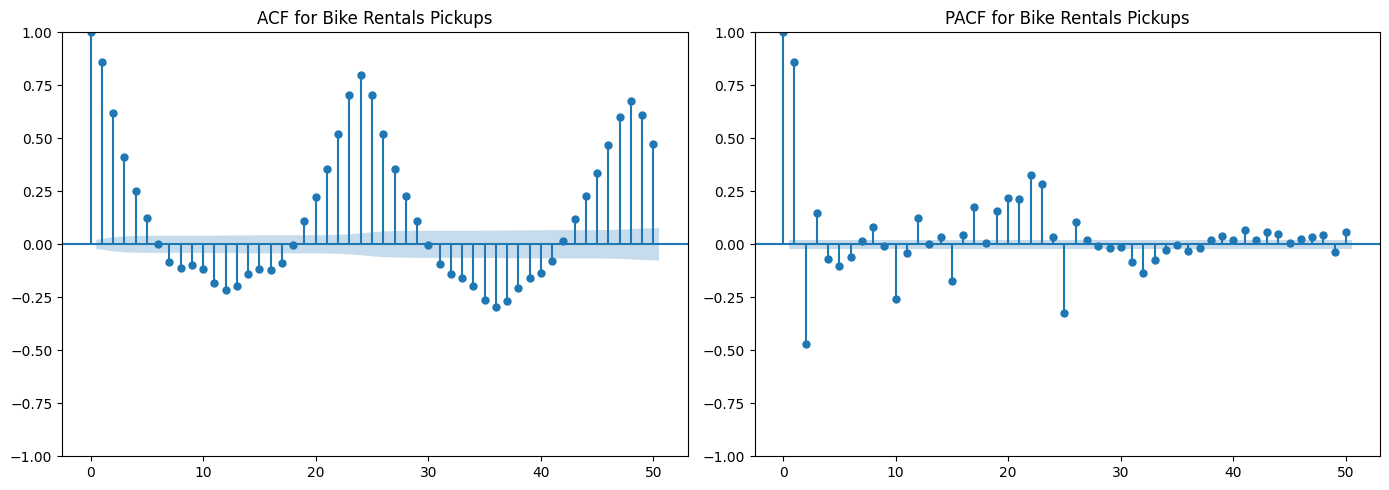

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=50, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f'ACF {title_suffix}')
    
    plot_pacf(series, lags=lags, ax=axes[1], method='ywm') 
    axes[1].set_title(f'PACF {title_suffix}')
    
    plt.tight_layout()
    plt.show()
plot_acf_pacf(hourly_cluster['num_rentals_pickups'], lags=50, title_suffix='for Bike Rentals Pickups')

ACF: decays slowly, crosses significance after lag 5, then rises at multiples of 24 hours.

PACF: significant at lag 0 and 1 positive, lag 2 negative, then essentially small values.

Slow decay in ACF → indicates strong autocorrelation / possible AR component.

PACF spikes at lag 1 → suggests AR(1) term is relevant.

ACF peaks at multiples of 24 hours → indicates daily seasonality (hourly data).

Beyond lag 5, ACF is mostly noise → MA terms may be limited to small lags.

## Train Time Series

In [14]:
##CONSTANTS
END_TRAINING_DATE = pd.to_datetime("2018-09-01 00:00:00")
END_VALIDATION_DATE = pd.to_datetime("2018-11-01 00:00:00")

## Split train - Test

In [15]:
train_data = hourly_cluster[hourly_cluster['datetime'] < END_VALIDATION_DATE].set_index('datetime')
test_data = hourly_cluster[hourly_cluster['datetime'] >= END_VALIDATION_DATE].set_index('datetime')

train_data.index = pd.to_datetime(train_data.index)
test_data.index  = pd.to_datetime(test_data.index)

train_weather  = weather_cleaned[weather_cleaned['datetime'] < END_VALIDATION_DATE].set_index('datetime')
test_weather   = weather_cleaned[weather_cleaned['datetime'] >= END_VALIDATION_DATE].set_index('datetime')

In [16]:
train_data = train_data.asfreq('h')
test_data = test_data.asfreq('h')

In [17]:
train_exog = train_weather[['temp','feelslike','dew','humidity','precip','precipprob','snow','snowdepth','windspeed','sealevelpressure','visibility']]
train_exog.index = train_data.index

test_exog = test_weather[['temp','feelslike','dew','humidity','precip','precipprob','snow','snowdepth','windspeed','sealevelpressure','visibility']]
test_exog.index = test_data.index

train_exog_short = train_exog[['feelslike','precip','visibility']]

test_exog_short = test_exog[['feelslike','precip','visibility']]

In [18]:
def print_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    rmse = round(np.sqrt(mse), 2)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    return mae, rmse

def plot_predictions_vs_true(test_data, predicted_column, true_column):
        plt.figure(figsize=(15, 6))
        plt.plot(test_data.index, test_data[true_column], label='Actual', color='blue')
        plt.plot(test_data.index, test_data[predicted_column], label='Predicted', color='orange')
        plt.xlabel('Datetime')
        plt.ylabel('Number of Rentals')
        plt.title('ARIMA Model: Actual vs Predicted Number of Rentals')
        plt.legend()
        plt.show()
    

In [19]:
PICKUP_TARGET_COL = 'num_rentals_pickups'
DROPOFF_TARGET_COL = 'num_rentals_dropoffs'

In [20]:
performance_pickup = {}
performance_dropoffs= {}

# PREDICTION OF PICK UPS

In [21]:
folds_config = [
    {'train_start': pd.Timestamp('2018-01-01 00:00:00'), 
     'train_end': pd.Timestamp('2018-06-30 23:00:00'),
     'val_start': pd.Timestamp('2018-07-01 00:00:00'), 
     'val_end': pd.Timestamp('2018-08-31 23:00:00')},
    {'train_start': pd.Timestamp('2018-01-01 00:00:00'), 
     'train_end': pd.Timestamp('2018-08-31 23:00:00'),
     'val_start': pd.Timestamp('2018-09-01 00:00:00'), 
     'val_end': pd.Timestamp('2018-10-31 23:00:00')}
]

### After looking at ACF and PACF we try a SARIMA model

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax_fit_predict_folds(folds_config, train_data, target, order, s_order, exog=None):

    maes = []
    rmses = []

    for i, fold in enumerate(folds_config, 1):
        train_fold = train_data.loc[fold['train_start']:fold['train_end']]
        val_fold   = train_data.loc[fold['val_start']:fold['val_end']].copy()

        if exog is not None:
            exog_train = exog.loc[fold['train_start']:fold['train_end']]
            exog_val   = exog.loc[fold['val_start']:fold['val_end']]
        else:
            exog_train = None
            exog_val = None

        # Fit SARIMAX
        model = SARIMAX(
            train_fold[target],
            exog=exog_train,
            order=order,
            seasonal_order=s_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        print(f"Fold {i} SARIMAX summary:")
        print(model_fit.summary())

        # Forecast
        n_steps = len(val_fold)
        predictions = model_fit.forecast(steps=n_steps, exog=exog_val)
        predictions = np.clip(predictions, 0, None) 
        val_fold["predictions"]= predictions.values

        # Metrics
        mae_fold, rmse_fold = print_metrics(val_fold[target], val_fold["predictions"])
        maes.append(mae_fold)
        rmses.append(rmse_fold)

    avg_mae = np.round(np.mean(maes),2)
    avg_rmse = np.round(np.mean(rmses),2)
    return avg_mae, avg_rmse

def sarimax_fit_predict(train_data, test_data, target, order,s_order, new_col, exog_train = None, exog_test = None):
    model = SARIMAX(
    train_data[target],
    exog= exog_train,
    order=order,             
    seasonal_order=s_order, 
    enforce_stationarity=False,
    enforce_invertibility=False
)
    model_fit = model.fit()
    print(model_fit.summary())

    n_steps = len(test_data)
    predictions = model_fit.forecast(steps=n_steps, exog=exog_test)
    predictions = np.clip(predictions, 0, None)
    test_data[new_col] = predictions.values

    mae, rmse = print_metrics(test_data[target], test_data[new_col])
    plot_predictions_vs_true(test_data, new_col, target)
    return mae, rmse


In [25]:
s_order = (1,0,1,24) #24 hours per day
order=(1,0,4)
print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds(folds_config, train_data, PICKUP_TARGET_COL, order,s_order)
performance_pickup["model_sarima"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order)
performance_dropoffs["model_sarima"] = {"val_mae": mae, "val_rmse": rmse}

Prediciting num_rentals_pickups


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23859.031
Date:                              Sat, 29 Nov 2025   AIC                          47734.063
Time:                                      15:42:37   BIC                          47785.021
Sample:                                  01-01-2018   HQIC                         47752.057
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9667      0.018    -53.641      0.000      -1.002      -0

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32533.986
Date:                              Sat, 29 Nov 2025   AIC                          65083.973
Time:                                      15:42:58   BIC                          65137.302
Sample:                                  01-01-2018   HQIC                         65102.523
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9186      0.039    -23.758      0.000      -0.994      -0

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23773.627
Date:                              Sat, 29 Nov 2025   AIC                          47563.255
Time:                                      15:43:15   BIC                          47614.214
Sample:                                  01-01-2018   HQIC                         47581.249
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5544      0.100     -5.520      0.000      -0.751      -0

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32528.810
Date:                              Sat, 29 Nov 2025   AIC                          65073.621
Time:                                      15:43:35   BIC                          65126.950
Sample:                                  01-01-2018   HQIC                         65092.171
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4778      0.164      2.915      0.004       0.157       0

### 3. We add exogenous variables

In [26]:
print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds(folds_config, train_data, PICKUP_TARGET_COL, order,s_order, train_exog)
performance_pickup["model_sarimax"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order, train_exog)
performance_dropoffs["model_sarimax"] = {"val_mae": mae, "val_rmse": rmse}

Prediciting num_rentals_pickups


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -24086.047
Date:                              Sat, 29 Nov 2025   AIC                          48210.093
Time:                                      15:44:37   BIC                          48331.120
Sample:                                  01-01-2018   HQIC                         48252.829
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                -9.5225      5.674     -1.678      0.093  

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32868.266
Date:                              Sat, 29 Nov 2025   AIC                          65774.532
Time:                                      15:45:58   BIC                          65901.189
Sample:                                  01-01-2018   HQIC                         65818.590
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                -4.7586      5.699     -0.835      0.404  

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23852.548
Date:                              Sat, 29 Nov 2025   AIC                          47743.096
Time:                                      15:46:53   BIC                          47864.123
Sample:                                  01-01-2018   HQIC                         47785.832
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp               -10.3920      5.324     -1.952      0.051  

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32550.596
Date:                              Sat, 29 Nov 2025   AIC                          65139.192
Time:                                      15:48:12   BIC                          65265.849
Sample:                                  01-01-2018   HQIC                         65183.250
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                -6.4226      5.300     -1.212      0.226  

### 3. We keep only the relevant exogenous variables

In [27]:
print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds(folds_config, train_data, PICKUP_TARGET_COL, order,s_order, train_exog_short)
performance_pickup["model_sarimax_short"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order, train_exog_short)
performance_dropoffs["model_sarimax_short"] = {"val_mae": mae, "val_rmse": rmse}

Prediciting num_rentals_pickups


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23760.294
Date:                              Sat, 29 Nov 2025   AIC                          47542.588
Time:                                      15:48:50   BIC                          47612.656
Sample:                                  01-01-2018   HQIC                         47567.330
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      3.8371      0.553      6.934      0.000       2.752       4

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32486.105
Date:                              Sat, 29 Nov 2025   AIC                          64994.210
Time:                                      15:49:42   BIC                          65067.537
Sample:                                  01-01-2018   HQIC                         65019.717
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      3.8356      0.700      5.477      0.000       2.463       5

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23487.732
Date:                              Sat, 29 Nov 2025   AIC                          46997.464
Time:                                      15:50:22   BIC                          47067.532
Sample:                                  01-01-2018   HQIC                         47022.206
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      3.8436      0.546      7.039      0.000       2.773       4

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -32212.369
Date:                              Sat, 29 Nov 2025   AIC                          64446.737
Time:                                      15:51:14   BIC                          64520.064
Sample:                                  01-01-2018   HQIC                         64472.244
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      4.3450      0.620      7.005      0.000       3.129       5

## 4. Adding day and hour

In [28]:
train_exog_w_date = train_weather[['feelslike','precip','visibility', 'day_of_week', 'hour_of_day']]
train_exog_w_date = pd.get_dummies(train_exog_w_date, columns=['hour_of_day', 'day_of_week'], drop_first=True).astype(float)
train_exog_w_date.index = train_data.index

test_exog_w_date = test_weather[['feelslike','precip','visibility', 'day_of_week', 'hour_of_day']]
test_exog_w_date = pd.get_dummies(test_exog_w_date, columns=['hour_of_day', 'day_of_week'], drop_first=True).astype(float)
test_exog_w_date.index = test_data.index

print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds(folds_config, train_data, PICKUP_TARGET_COL, order,s_order, train_exog_w_date)
performance_pickup["model_sarimax_short_w_date"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order, train_exog_w_date)
performance_dropoffs["model_sarimax_short_w_date"] = {"val_mae": mae, "val_rmse": rmse}

Prediciting num_rentals_pickups
Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23405.172
Date:                              Sat, 29 Nov 2025   AIC                          46890.343
Time:                                      15:53:46   BIC                          47145.137
Sample:                                  01-01-2018   HQIC                         46980.314
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
feelslike          5.2269      0.2

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -31872.806
Date:                              Sat, 29 Nov 2025   AIC                          63825.611
Time:                                      15:56:46   BIC                          64092.256
Sample:                                  01-01-2018   HQIC                         63918.365
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
feelslike          2.3679      0.441      5.372      0.000       1

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -23220.761
Date:                              Sat, 29 Nov 2025   AIC                          46521.521
Time:                                      15:58:32   BIC                          46776.316
Sample:                                  01-01-2018   HQIC                         46611.492
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
feelslike          6.2203      0.274     22.701      0.000       5

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -31545.040
Date:                              Sat, 29 Nov 2025   AIC                          63170.080
Time:                                      16:00:50   BIC                          63436.725
Sample:                                  01-01-2018   HQIC                         63262.833
                                       - 08-31-2018                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
feelslike          4.6358      0.262     17.684      0.000       4

In [29]:
performance_pickup

{'model_24': {'val_mae': 175.995, 'val_rmse': 224.065},
 'model_sarima': {'val_mae': 98.14, 'val_rmse': 151.82},
 'model_sarimax': {'val_mae': 98.16, 'val_rmse': 132.48},
 'model_sarimax_short': {'val_mae': 88.08, 'val_rmse': 128.5},
 'model_sarimax_short_w_date': {'val_mae': 94.3, 'val_rmse': 122.6}}

# NN

In [30]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [31]:
def get_dataset(hourly_cluster,n_lags, forecast_horizon, target):
    train_data_nn = hourly_cluster.set_index('datetime')
    # --- Create lag features ---
    df = train_data_nn[[target]].copy()
    lags= {f'target_lag_{lag}': df[target].shift(lag) for lag in range(1, n_lags+1)}
    lags_df = pd.DataFrame(lags, index=df.index)
    df = pd.concat([df, lags_df], axis=1)

    exog_features = ['day_of_week','hour_of_day','feelslike', 'precip', 'visibility']
    df[exog_features] = weather_cleaned.set_index('datetime')[exog_features].loc[df.index]

    # --- Create multi-step target ---
    for step in range(1, forecast_horizon + 1):
        df[f'target_+{step}'] = df[target].shift(-step)

    # --- Drop rows with NaNs due to lags or forward targets ---
    all_columns = [f'target_lag_{lag}' for lag in range(1, n_lags + 1)] + exog_features + \
              [f'target_+{step}' for step in range(1, forecast_horizon + 1)]

    df = df.dropna(subset=all_columns)

    return df

# --- Parameters ---
n_lags = 168        # previous week of hourly data
forecast_horizon = 24  # next 24 hours

df_pickup = get_dataset(hourly_cluster, n_lags, forecast_horizon, PICKUP_TARGET_COL)
df_dropoff =get_dataset(hourly_cluster, n_lags, forecast_horizon, DROPOFF_TARGET_COL)

In [32]:
def split_datesets(df, END_TRAINING_DATE, END_VALIDATION_DATE, target, exog_features, forecast_horizon):

    X = df[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values
    y = df[[f'target_+{step}' for step in range(1, forecast_horizon+1)]].values

    X_train = X[df.index < END_TRAINING_DATE]
    y_train = y[df.index < END_TRAINING_DATE]

    X_val = X[(df.index >= END_TRAINING_DATE) & (df.index < END_VALIDATION_DATE)]
    y_val = y[(df.index >= END_TRAINING_DATE) & (df.index < END_VALIDATION_DATE)]

    X_train_final = X[df.index < END_VALIDATION_DATE]
    y_train_final = y[df.index < END_VALIDATION_DATE]

    X_test = X[df.index >= END_VALIDATION_DATE]
    y_test = y[df.index >= END_VALIDATION_DATE]

    return X_train, y_train, X_val, y_val, X_train_final, y_train_final, X_test, y_test

exog_features = ['day_of_week','hour_of_day','feelslike', 'precip', 'visibility']

X_p_train, y_p_train, X_p_val, y_p_val, X_p_train_final, y_p_train_final, X_p_test, y_p_test = split_datesets(df_pickup, END_TRAINING_DATE, END_VALIDATION_DATE,PICKUP_TARGET_COL,exog_features,forecast_horizon)

X_d_train, y_d_train, X_d_val, y_d_val, X_d_train_final, y_d_train_final, X_d_test, y_d_test = split_datesets(df_dropoff, END_TRAINING_DATE, END_VALIDATION_DATE,DROPOFF_TARGET_COL,exog_features,forecast_horizon)

In [33]:
from sklearn.preprocessing import StandardScaler

# Pickups
scaler_pickup = StandardScaler()
X_pickup_train_scaled = scaler_pickup.fit_transform(X_p_train)
X_pickup_val_scaled = scaler_pickup.transform(X_p_val)

# Dropoffs
scaler_dropoff = StandardScaler()
X_dropoff_train_scaled = scaler_dropoff.fit_transform(X_d_train)
X_dropoff_val_scaled = scaler_dropoff.transform(X_d_val)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

def create_nn_and_train(X_train_scaled, y_train):

    model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(forecast_horizon) 
        ])
    
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
    return model

def predict_nn(model, X_val_scaled, y_val):
    y_pred = model.predict(X_val_scaled)
    y_pred = np.clip(y_pred, 0, None)

    mae_per_hour = mean_absolute_error(y_val, y_pred, multioutput='raw_values')
    rmse_per_hour = root_mean_squared_error(y_val, y_pred, multioutput='raw_values')

    mae = np.round(np.mean(mae_per_hour), 2)
    rmse= np.round(np.mean(rmse_per_hour),2)
    return mae, rmse


In [35]:
p_train_model = create_nn_and_train(X_pickup_train_scaled, y_p_train)
mae_p_train, rmse_p_train = predict_nn(p_train_model, X_pickup_val_scaled, y_p_val)
performance_pickup["model_nn"] = {"val_mae": np.round(np.mean(mae_p_train),2), "val_rmse": np.round(np.mean(rmse_p_train),2)}

Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 50301.8906 - val_loss: 36039.6289
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 19146.4590 - val_loss: 22311.6133
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 15829.2178 - val_loss: 19208.1855
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 14533.9189 - val_loss: 17399.1387
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 13780.8633 - val_loss: 16350.3584
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 13026.7490 - val_loss: 15586.9443
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 12568.9658 - val_loss: 14556.2227
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 12061.8154 - val_loss: 13805.6309
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 11749.2197 - val_loss: 13150.5801
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 11304.4355 - val_loss: 12667.9951
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/st

In [36]:
d_train_model = create_nn_and_train(X_dropoff_train_scaled, y_d_train)
mae_d_train, rmse_d_train = predict_nn(d_train_model, X_dropoff_val_scaled, y_d_val)
performance_dropoffs["model_nn"] = {"val_mae": np.round(np.mean(mae_d_train),2), "val_rmse": np.round(np.mean(rmse_d_train),2)}

Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 48392.4961 - val_loss: 31389.6055
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 17660.9219 - val_loss: 21108.3828
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 14989.9961 - val_loss: 18079.5293
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 13947.3281 - val_loss: 16888.9453
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 13125.2959 - val_loss: 15434.4346
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 12545.2549 - val_loss: 14469.8721
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 12093.4590 - val_loss: 13691.4482
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 11520.0947 - val_loss: 12990.6572
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 11146.9102 - val_loss: 12537.8164
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 10798.8916 - val_loss: 12033.9688
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/st

In [37]:
performance_pickup

{'model_24': {'val_mae': 175.995, 'val_rmse': 224.065},
 'model_sarima': {'val_mae': 98.14, 'val_rmse': 151.82},
 'model_sarimax': {'val_mae': 98.16, 'val_rmse': 132.48},
 'model_sarimax_short': {'val_mae': 88.08, 'val_rmse': 128.5},
 'model_sarimax_short_w_date': {'val_mae': 94.3, 'val_rmse': 122.6},
 'model_nn': {'val_mae': 61.8, 'val_rmse': 95.47}}

## Comparison of performance of best time series model and NN on pick ups

### NEURAL NETWORK

In [38]:
# Pickups
scaler_pickup = StandardScaler()
X_pickup_final_scaled = scaler_pickup.fit_transform(X_p_train_final)
X_pickup_test_scaled = scaler_pickup.transform(X_p_test)

In [39]:
p_final_model = create_nn_and_train(X_pickup_final_scaled, y_p_train_final)
mae_p_final, rmse_p_final = predict_nn(p_final_model, X_pickup_test_scaled, y_p_test)
print(f"val_mae {np.round(np.mean(mae_p_final),2)}, val_rmse: {np.round(np.mean(rmse_p_final),2)}")

Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49371.3711 - val_loss: 27505.7090
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 18389.1504 - val_loss: 20820.9922
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 16036.8428 - val_loss: 18184.2031
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 14860.1328 - val_loss: 16788.1934
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 13966.7412 - val_loss: 15736.3418
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 13299.0225 - val_loss: 14698.4600
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 12576.2344 - val_loss: 13772.1582
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 12138.1299 - val_loss: 12654.6006
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 11624.5068 - val_loss: 12589.9131
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 11225.8477 - val_loss: 11909.8320
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/st

### SARIMAX

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.74261D+00    |proj g|=  1.68381D-01

At iterate    5    f=  5.71505D+00    |proj g|=  1.95712D-02

At iterate   10    f=  5.67282D+00    |proj g|=  1.10157D+00

At iterate   15    f=  5.66893D+00    |proj g|=  4.99157D-02

At iterate   20    f=  5.66774D+00    |proj g|=  6.91596D-03

At iterate   25    f=  5.66715D+00    |proj g|=  6.06892D-02

At iterate   30    f=  5.66486D+00    |proj g|=  1.17864D-01

At iterate   35    f=  5.63860D+00    |proj g|=  7.54380D-01

At iterate   40    f=  5.61937D+00    |proj g|=  1.41289D+00

At iterate   45    f=  5.61443D+00    |proj g|=  6.97878D-01

At iterate   50    f=  5.60856D+00    |proj g|=  1.09509D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 7296
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -40920.083
Date:                              Sat, 29 Nov 2025   AIC                          81862.166
Time:                                      16:02:25   BIC                          81937.968
Sample:                                  01-01-2018   HQIC                         81888.237
                                       - 10-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      3.4777      0.422      8.248      0.000       2.651       4.304
precip        -4.89

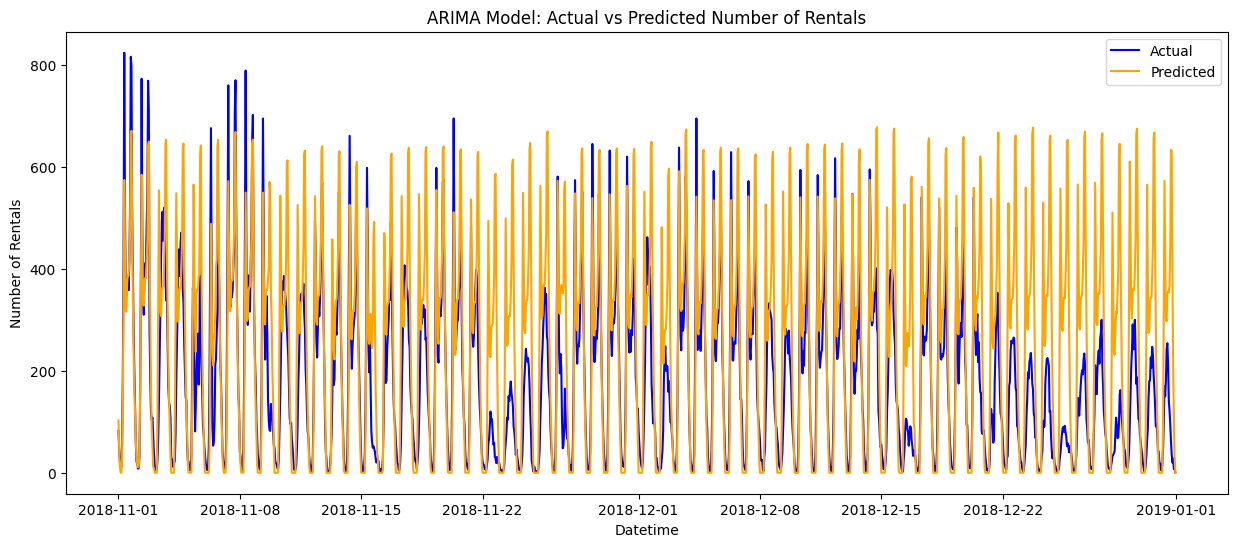

In [40]:
new_col = f'pred_{PICKUP_TARGET_COL}'
mae, rmse = sarimax_fit_predict(train_data, test_data, PICKUP_TARGET_COL, order, s_order, new_col, train_exog_short, test_exog_short)


## Comparison of performance of best time series model and NN on dropoffs

### NEURAL NETWORK

In [41]:
scaler_dropoff = StandardScaler()
X_dropoff_final_scaled = scaler_dropoff.fit_transform(X_d_train_final)
X_dropoff_test_scaled = scaler_dropoff.transform(X_d_test)

In [42]:
d_final_model = create_nn_and_train(X_dropoff_final_scaled, y_d_train_final)
mae_d_final, rmse_d_final = predict_nn(d_final_model, X_dropoff_test_scaled, y_d_test)
print(f"val_mae {np.round(np.mean(mae_d_final),2)}, val_rmse: {np.round(np.mean(rmse_d_final),2)}")

Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49474.8750 - val_loss: 28747.6074
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 18124.1562 - val_loss: 19813.2012
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 15402.1006 - val_loss: 17441.6152
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 14391.6689 - val_loss: 16193.5752
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 13642.6826 - val_loss: 15060.8896
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 12895.5947 - val_loss: 14205.3896
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 12338.5996 - val_loss: 13241.4961
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 11947.6201 - val_loss: 12693.7920
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 11498.7236 - val_loss: 12338.4473
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 11127.0029 - val_loss: 12287.3984
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/st

## SARIMAX

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69472D+00    |proj g|=  1.99210D-01

At iterate    5    f=  5.66149D+00    |proj g|=  2.07245D-02

At iterate   10    f=  5.61697D+00    |proj g|=  6.64939D-01

At iterate   15    f=  5.61367D+00    |proj g|=  2.40933D-02

At iterate   20    f=  5.61290D+00    |proj g|=  5.98953D-03

At iterate   25    f=  5.61278D+00    |proj g|=  1.02010D-01

At iterate   30    f=  5.60956D+00    |proj g|=  3.30018D-01

At iterate   35    f=  5.60558D+00    |proj g|=  1.25549D-01

At iterate   40    f=  5.58758D+00    |proj g|=  1.91064D+00

At iterate   45    f=  5.58249D+00    |proj g|=  3.75714D-01


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.58110D+00    |proj g|=  1.14784D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     89      1     0     0   1.148D-01   5.581D+00
  F =   5.5810953970419472     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                 num_rentals_dropoffs   No. Observations:                 7296
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -40719.672
Date:                              Sat, 29 Nov 2025   AIC                         

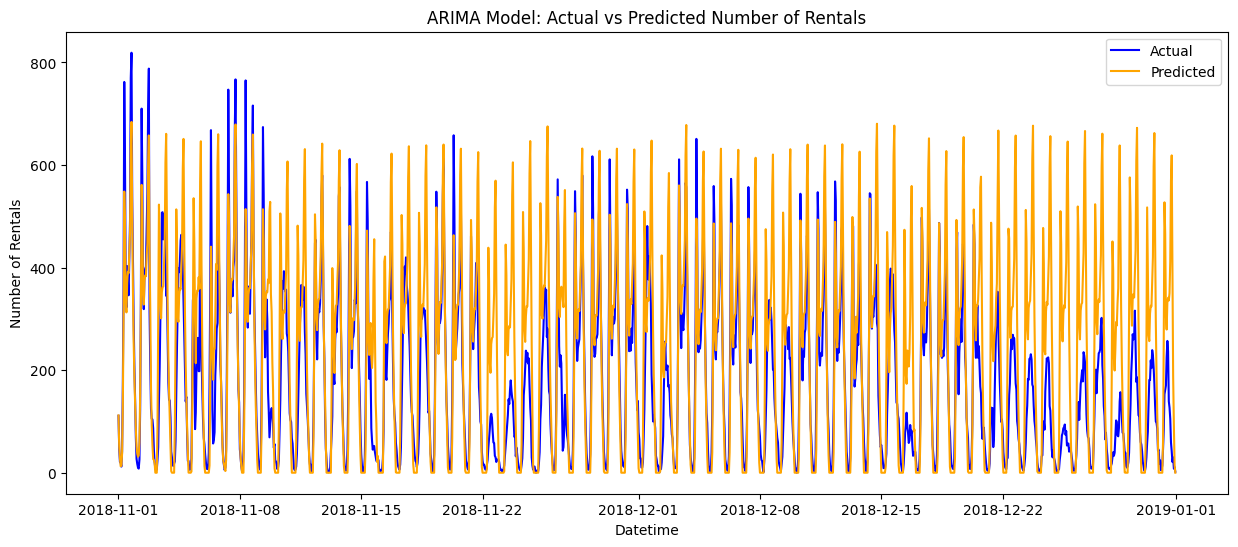

In [43]:
new_col = f'pred_{DROPOFF_TARGET_COL}'
mae, rmse = sarimax_fit_predict(train_data, test_data, DROPOFF_TARGET_COL, order, s_order, new_col, train_exog_short, test_exog_short)


In [44]:
performance_dropoffs

{'model_24': {'val_mae': 175.125, 'val_rmse': 222.22},
 'model_sarima': {'val_mae': 84.12, 'val_rmse': 131.95},
 'model_sarimax': {'val_mae': 100.44, 'val_rmse': 133.84},
 'model_sarimax_short': {'val_mae': 84.85, 'val_rmse': 125.12},
 'model_sarimax_short_w_date': {'val_mae': 104.94, 'val_rmse': 131.21},
 'model_nn': {'val_mae': 62.19, 'val_rmse': 94.94}}

In [45]:
performance_pickup

{'model_24': {'val_mae': 175.995, 'val_rmse': 224.065},
 'model_sarima': {'val_mae': 98.14, 'val_rmse': 151.82},
 'model_sarimax': {'val_mae': 98.16, 'val_rmse': 132.48},
 'model_sarimax_short': {'val_mae': 88.08, 'val_rmse': 128.5},
 'model_sarimax_short_w_date': {'val_mae': 94.3, 'val_rmse': 122.6},
 'model_nn': {'val_mae': 61.8, 'val_rmse': 95.47}}

# Task 3

In [49]:
stations

,station_id,station_latitude,station_longitude,category,station_cluster
0,315.0,40.7036,-74.0067,both,27
1,3224.0,40.7400,-74.0051,both,26
2,386.0,40.7149,-74.0023,both,5
3,466.0,40.7440,-73.9914,both,22
4,438.0,40.7278,-73.9856,both,11
...,...,...,...,...,...
843,3678.0,40.7257,-74.0720,end,19
844,3187.0,40.7211,-74.0381,end,10
845,3639.0,40.7193,-74.0342,end,10
846,3277.0,40.7144,-74.0666,end,19


In [62]:
required_bikes_per_cluster={}

for cluster_id in avg_bikes_per_cluster["station_cluster"]:
    cluster = data[data['station_cluster'] == cluster_id]
    print(f'cluster_id: {cluster_id}')
    hourly_pickups_cluster = cluster.groupby(['pickup_datetime'])['bikeid'].size().reset_index(name='num_rentals')
    hourly_dropoffs_cluster = cluster.groupby(['dropoff_datetime'])['bikeid'].size().reset_index(name='num_rentals')
    hourly_cluster = pd.merge(hourly_pickups_cluster, hourly_dropoffs_cluster, left_on='pickup_datetime', right_on='dropoff_datetime', how='outer', suffixes=('_pickups', '_dropoffs')).drop(columns=['dropoff_datetime']).rename(columns={'pickup_datetime': 'datetime'})
    hourly_cluster['datetime'] = pd.to_datetime(hourly_cluster['datetime'])
    hourly_cluster = hourly_cluster[hourly_cluster['datetime'] < '2019-01-01']

    print(f'size of hourly_cluster: {hourly_cluster.shape}')
    hourly_cluster = fill_missing_hours(hourly_cluster)
    print(f'size of hourly_cluster after filling missing hours: {hourly_cluster.shape}')

    train_data = hourly_cluster.set_index('datetime')
    train_data.index = pd.to_datetime(train_data.index)

    exog  = weather_cleaned.set_index('datetime')
    df_pickup = get_dataset(hourly_cluster, n_lags, forecast_horizon, PICKUP_TARGET_COL)
    df_dropoff =get_dataset(hourly_cluster, n_lags, forecast_horizon, DROPOFF_TARGET_COL)

    last_pickup =  df_pickup.iloc[-1].copy()
    df_pickup_train = df_pickup.iloc[:-1].copy()
    last_dropoff =  df_dropoff.iloc[-1].copy()
    df_dropoff_train = df_dropoff.iloc[:-1].copy()


    X_pickup = df_pickup_train[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values
    y_pickup = df_pickup_train[[f'target_+{step}' for step in range(1, forecast_horizon+1)]].values
    last_pickup_to_predict = last_pickup[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values.reshape(1, -1)
  
    X_dropoff = df_dropoff_train[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values
    y_dropoff = df_dropoff_train[[f'target_+{step}' for step in range(1, forecast_horizon+1)]].values
    last_dropoff_to_predict = last_dropoff[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values.reshape(1, -1)

    scaler_pickup = StandardScaler()
    X_pickup_train_scaled = scaler_pickup.fit_transform(X_pickup)
    last_pickup_to_predict_scaled = scaler_pickup.transform(last_pickup_to_predict)

    scaler_dropoff = StandardScaler()
    X_dropoff_train_scaled = scaler_dropoff.fit_transform(X_dropoff)
    last_dropoff_to_predict_scaled = scaler_dropoff.transform(last_dropoff_to_predict)
    
    p_final_model = create_nn_and_train(X_pickup_train_scaled, y_pickup)
    d_final_model = create_nn_and_train(X_dropoff_final_scaled, y_dropoff)

    p_pred = np.round(np.clip(p_final_model.predict(last_pickup_to_predict_scaled), 0, None))
    d_pred = np.round(np.clip(d_final_model.predict(last_dropoff_to_predict_scaled), 0 ,None))

    cum_net = np.cumsum(d_pred - p_pred)
    required_bikes = max(0, -cum_net.min())
    required_bikes_per_cluster[cluster_id] = required_bikes

cluster_id: 11
size of hourly_cluster: (8721, 3)
size of hourly_cluster after filling missing hours: (8760, 3)
Epoch 1/50


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 46988.9727 - val_loss: 14883.4170
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 18620.6797 - val_loss: 12470.1123
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 16320.3662 - val_loss: 11547.5068
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 15204.1592 - val_loss: 10817.5576
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 14128.9941 - val_loss: 10143.9062
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 13377.0195 - val_loss: 9449.3916
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 12628.3125 - val_loss: 9045.4287
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 12156.0205 - val_loss: 8792.4053
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 11861.6064 - val_loss: 8575.3223
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 11595.0166 - val_loss: 8407.7383
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - 

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - loss: 48282.9180 - val_loss: 16986.8848
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 20729.6875 - val_loss: 14556.4316
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 17965.5312 - val_loss: 13311.5127
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 16527.2148 - val_loss: 12550.3457
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 15678.6309 - val_loss: 11758.0918
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 14889.8662 - val_loss: 11151.4785
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 14098.8086 - val_loss: 10620.9844
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 13545.5059 - val_loss: 10193.0596
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 13131.7988 - val_loss: 9869.2275
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 12843.1016 - val_loss: 9639.4502
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/st

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - loss: 24926.5820 - val_loss: 6997.6099
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 9763.0781 - val_loss: 6267.2656
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 8647.9512 - val_loss: 5947.7056
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 8225.6328 - val_loss: 5688.4019
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 7848.4692 - val_loss: 5498.7036
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 7519.4150 - val_loss: 5264.8374
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 7262.4717 - val_loss: 5120.7817
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 6954.8438 - val_loss: 4948.9551
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 6761.7773 - val_loss: 4781.8843
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 6573.0605 - val_loss: 4630.5605
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 6443.4

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - loss: 22520.8633 - val_loss: 8066.9785
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 9410.6514 - val_loss: 6738.8408
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 8079.2969 - val_loss: 6234.8896
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 7457.8828 - val_loss: 5698.4634
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 6976.6660 - val_loss: 5351.3750
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 6627.3169 - val_loss: 5108.7012
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 6331.8896 - val_loss: 4921.9976
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 6139.5151 - val_loss: 4787.6030
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 5939.7080 - val_loss: 4680.1763
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 5901.8213 - val_loss: 4581.3843
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 5748.8

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - loss: 30480.4980 - val_loss: 13481.3271
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 15163.3994 - val_loss: 11234.1055
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 12978.4961 - val_loss: 9585.5791
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 11470.0332 - val_loss: 8618.6484
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 10665.6543 - val_loss: 8213.8154
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 10231.2988 - val_loss: 7906.4165
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 9822.9209 - val_loss: 7606.1768
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 9421.9736 - val_loss: 7273.1060
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 9082.9170 - val_loss: 6961.3379
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 8820.7217 - val_loss: 6671.5581
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss:

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 24018.1660 - val_loss: 6555.1826
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 10412.9580 - val_loss: 5834.8110
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 9437.2256 - val_loss: 5382.4658
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 8814.0117 - val_loss: 5076.2505
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 8429.7559 - val_loss: 4825.9360
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 8041.2275 - val_loss: 4663.4033
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 7755.5508 - val_loss: 4509.9937
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 7537.7744 - val_loss: 4409.2974
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 7299.4790 - val_loss: 4291.8389
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 7154.0532 - val_loss: 4212.6704
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 7023.12

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 15104.3330 - val_loss: 6140.0757
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 7092.4399 - val_loss: 5220.4487
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 6228.2036 - val_loss: 4693.8906
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 5608.0356 - val_loss: 4199.1465
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 5129.4150 - val_loss: 3872.7415
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 4837.1079 - val_loss: 3644.0085
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 4554.8628 - val_loss: 3495.3005
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 4427.0562 - val_loss: 3356.7085
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 4261.6694 - val_loss: 3211.0559
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 4145.7041 - val_loss: 3116.2170
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 4027.6

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - loss: 12983.4688 - val_loss: 4205.0220
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 5283.6582 - val_loss: 3645.4575
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 4733.2139 - val_loss: 3319.7502
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 4329.5186 - val_loss: 3017.6270
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 3977.4724 - val_loss: 2807.9111
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 3719.5435 - val_loss: 2694.4539
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 3599.0574 - val_loss: 2592.4307
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 3504.4197 - val_loss: 2514.2883
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 3404.3118 - val_loss: 2465.1382
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 3290.0281 - val_loss: 2423.0520
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 3233.3

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - loss: 9119.7520 - val_loss: 3200.2690
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 4748.0879 - val_loss: 2885.1704
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 4302.0918 - val_loss: 2611.5100
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 3894.2703 - val_loss: 2323.9546
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 3532.0344 - val_loss: 2118.9426
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 3341.1011 - val_loss: 2012.6865
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 3212.1848 - val_loss: 1909.9731
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 3088.6677 - val_loss: 1847.6062
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 3026.6252 - val_loss: 1754.7827
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 2903.6375 - val_loss: 1708.3914
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 2878.45

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8670.0518 - val_loss: 2605.5569
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 4015.8184 - val_loss: 2406.0366
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 3710.6448 - val_loss: 2257.2095
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 3458.8259 - val_loss: 2170.6995
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 3310.5344 - val_loss: 2101.1304
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 3204.9038 - val_loss: 2079.9680
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 3139.7136 - val_loss: 2005.9177
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 3038.4692 - val_loss: 1980.9683
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 2994.1831 - val_loss: 1953.3253
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 2949.5671 - val_loss: 1903.1776
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 2914.9365

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9549.6611 - val_loss: 2486.4365
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 4594.7080 - val_loss: 2201.1387
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 4184.7856 - val_loss: 2025.2662
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 3943.7561 - val_loss: 1905.4078
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 3789.9436 - val_loss: 1830.2037
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 3668.6287 - val_loss: 1760.1385
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 3536.9863 - val_loss: 1713.0701
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 3449.0476 - val_loss: 1652.9507
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 3370.6228 - val_loss: 1586.2816
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 3241.2517 - val_loss: 1522.1049
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 3170.3948

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - loss: 3256.5017 - val_loss: 1350.8762
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 1686.7943 - val_loss: 1205.3597
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 1509.2051 - val_loss: 1058.0830
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 1330.2855 - val_loss: 946.2424
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 1239.6458 - val_loss: 893.5410
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 1181.3857 - val_loss: 853.5553
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 1144.9495 - val_loss: 819.5345
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 1111.7522 - val_loss: 803.9594
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 1072.4861 - val_loss: 793.4940
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 1072.5272 - val_loss: 771.7822
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 1062.9243 - va

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - loss: 1861.5209 - val_loss: 720.2714
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 927.2858 - val_loss: 630.6353
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 801.4714 - val_loss: 554.9496
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 714.3484 - val_loss: 514.3297
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 684.5603 - val_loss: 489.9128
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 667.1998 - val_loss: 475.9626
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 640.9758 - val_loss: 463.9683
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 626.8430 - val_loss: 458.1539
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 622.5857 - val_loss: 443.1729
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 606.6815 - val_loss: 440.7011
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 597.3877 - val_loss: 434.8

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - loss: 1913.9935 - val_loss: 639.0396
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 912.0984 - val_loss: 522.6336
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 758.4102 - val_loss: 444.9030
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 686.2344 - val_loss: 410.6021
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 648.0734 - val_loss: 389.5217
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 617.6747 - val_loss: 371.3765
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 599.7390 - val_loss: 361.3207
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 583.7661 - val_loss: 347.5536
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 565.2264 - val_loss: 343.8960
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 557.8882 - val_loss: 337.5543
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 546.8813 - val_loss: 333.1

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - loss: 2028.5057 - val_loss: 589.0588
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 1120.7135 - val_loss: 540.1398
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 1019.1373 - val_loss: 492.9035
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 913.9351 - val_loss: 441.2255
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 858.3187 - val_loss: 413.4891
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 814.1390 - val_loss: 394.5575
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 787.2444 - val_loss: 384.7908
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 771.2992 - val_loss: 380.1860
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 755.8334 - val_loss: 370.7993
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 737.3326 - val_loss: 365.5446
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 725.8065 - val_loss: 359

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - loss: 1576.9491 - val_loss: 442.8784
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 783.3524 - val_loss: 384.1501
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 655.0671 - val_loss: 336.5753
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 586.3296 - val_loss: 313.7360
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 543.9504 - val_loss: 297.9858
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 530.2354 - val_loss: 288.4647
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 517.4739 - val_loss: 282.6375
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 503.3659 - val_loss: 277.7889
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 497.4515 - val_loss: 271.7634
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 488.1519 - val_loss: 266.4559
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 483.2841 - val_loss: 271.2

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - loss: 1253.5133 - val_loss: 475.1940
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 619.5830 - val_loss: 370.4780
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 510.8613 - val_loss: 324.0205
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 466.7242 - val_loss: 302.5735
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 438.1453 - val_loss: 288.9747
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 422.8008 - val_loss: 280.8051
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 407.7501 - val_loss: 273.5603
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 401.9505 - val_loss: 265.2274
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 390.8389 - val_loss: 264.7711
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 383.7112 - val_loss: 259.8022
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 378.8853 - val_loss: 256.9

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - loss: 632.7395 - val_loss: 253.7220
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 299.7133 - val_loss: 216.2757
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 263.6464 - val_loss: 198.1949
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 242.0602 - val_loss: 191.1129
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 229.9226 - val_loss: 183.0062
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 221.6790 - val_loss: 179.0820
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 215.8691 - val_loss: 178.4464
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 212.6598 - val_loss: 176.0136
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 209.9157 - val_loss: 172.6015
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 209.9528 - val_loss: 175.3371
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 203.6952 - val_loss: 171.22

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - loss: 753.3387 - val_loss: 252.0789
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 434.4613 - val_loss: 205.6093
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 367.7140 - val_loss: 176.4384
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 335.8358 - val_loss: 163.3824
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 322.6991 - val_loss: 155.1946
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 308.9972 - val_loss: 148.0933
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 298.3033 - val_loss: 144.6886
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 295.1688 - val_loss: 144.5919
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 286.4662 - val_loss: 142.4967
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 284.0144 - val_loss: 142.2797
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 282.2277 - val_loss: 140.39

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - loss: 526.2669 - val_loss: 230.2820
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 263.3239 - val_loss: 199.5301
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 231.5146 - val_loss: 180.9090
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 214.9721 - val_loss: 172.6773
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 204.1349 - val_loss: 166.4089
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 199.0410 - val_loss: 161.0829
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 192.9239 - val_loss: 156.5439
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 188.9795 - val_loss: 154.1616
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 186.1029 - val_loss: 153.6770
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 184.4362 - val_loss: 154.6772
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 181.6603 - val_loss: 152.22

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 508.8342 - val_loss: 193.4063
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 258.4714 - val_loss: 152.1902
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 216.9160 - val_loss: 136.9266
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 198.3496 - val_loss: 128.8662
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 189.1414 - val_loss: 125.0938
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 181.8996 - val_loss: 120.9646
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 178.7154 - val_loss: 120.4678
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 173.3576 - val_loss: 117.8183
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 171.2137 - val_loss: 118.2708
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 170.7828 - val_loss: 117.0333
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 168.5469 - val_loss: 116.31

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 494.4390 - val_loss: 174.7073
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 264.1952 - val_loss: 146.3382
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 230.3203 - val_loss: 128.1978
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 211.5328 - val_loss: 119.8214
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 199.4735 - val_loss: 117.0515
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 194.6917 - val_loss: 113.3535
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 187.2661 - val_loss: 111.4586
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 185.0880 - val_loss: 111.5919
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 182.4133 - val_loss: 111.7216
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 178.8510 - val_loss: 107.9673
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 178.1171 - val_loss: 107.8841

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - loss: 286.7481 - val_loss: 95.7058
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 143.8452 - val_loss: 82.2599
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 124.2594 - val_loss: 75.4699
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 116.4335 - val_loss: 72.7098
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 112.1370 - val_loss: 71.1440
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 108.4511 - val_loss: 69.5683
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 105.3911 - val_loss: 68.4511
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 103.8410 - val_loss: 67.2374
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 102.4334 - val_loss: 67.9376
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 101.8808 - val_loss: 67.7475
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 99.8360 - val_loss: 67.0757
Epoch 12/

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - loss: 214.0601 - val_loss: 56.8503
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 111.4471 - val_loss: 46.8451
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 96.2852 - val_loss: 44.5066
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 90.6012 - val_loss: 42.4822
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 86.1437 - val_loss: 41.5387
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 84.2689 - val_loss: 40.9585
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 82.6951 - val_loss: 40.2461
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 80.4899 - val_loss: 40.4364
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 80.1550 - val_loss: 40.0970
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 78.4202 - val_loss: 40.3250
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 77.1960 - val_loss: 39.5410
Epoch 12/50
215/2

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 181.7457 - val_loss: 59.3507
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 99.4321 - val_loss: 50.2579
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 87.1796 - val_loss: 46.0720
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 80.2958 - val_loss: 43.8028
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 77.1799 - val_loss: 42.6985
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 75.2569 - val_loss: 42.7203
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 73.9967 - val_loss: 42.9966
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 71.9061 - val_loss: 42.1555
Epoch 9/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 71.2554 - val_loss: 41.6454
Epoch 10/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 71.2321 - val_loss: 41.6018
Epoch 11/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 69.9102 - val_loss: 41.2010
Epoch 12/50
215/215 

In [63]:
required_bikes_per_cluster

{11: 0,
 22: 434.0,
 26: 14.0,
 1: 73.0,
 8: 364.0,
 5: 139.0,
 16: 4.0,
 4: 10.0,
 13: 8.0,
 17: 294.0,
 27: 120.0,
 3: 6.0,
 12: 0,
 24: 0,
 21: 0,
 18: 37.0,
 6: 0,
 25: 35.0,
 23: 77.0,
 7: 18.0,
 20: 8.0,
 15: 27.0,
 2: 2.0,
 14: 6.0,
 9: 43.0}